This cell initializes the project paths and configuration so the notebook runs reliably on any machine. It first resolves the raw MAUDE data directory (preferring the MAUDE_RAW environment variable, with a Mac fallback), then derives standardized output folders for tables and figures and verifies they’re writable. It records key analysis parameters—time window, intervention quarter, plotting limits, and reproducibility seed—so later cells don’t hard-code values. The cell inventories expected ZIP files (devices, narratives, events, codes) and prints any missing items to catch setup problems early. Finally, it saves a lightweight config.json with paths, parameters, and Python version to document the environment and support reproducibility.

In [1]:
# === Cell 01: Config & Paths (cross-platform, hardened) ===
from pathlib import Path
import json, os, sys, platform
from datetime import datetime

# --- RAW DIR: env first, then Mac fallback ---
RAW_DIR = Path(os.environ.get(
    "MAUDE_RAW",
    "/Users/michaelmohle/Desktop/DS_archive/WGU/D502/capstone-maude/Data/raw/Maude"
)).expanduser().resolve()

assert RAW_DIR.exists(), f"RAW_DIR not found: {RAW_DIR}"

# --- Project/output dirs ---
PROJECT_ROOT = RAW_DIR.parent.parent
OUT_ROOT = PROJECT_ROOT / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_FIG  = OUT_ROOT / "figures"
for p in (OUT_ROOT, OUT_TAB, OUT_FIG): p.mkdir(parents=True, exist_ok=True)

# --- Analysis params in one place ---
PARAMS = dict(
    WINDOW_START="2021-Q1",
    WINDOW_END="2024-Q4",
    BREAK_QUARTER="2024-Q1",
    TARGET_INDEX=0,
    N_TOP_BRANDS=12,
    RANDOM_SEED=42,
    STRICT_ZIP_CHECK=False,  # set True to hard-fail if any expected ZIP missing
)

# --- Expected raw files ---
expected_files = {
    "device2021.zip","device2022.zip","device2023.zip","device2024.zip",
    "deviceproblemcodes.zip","foidevproblem.zip",
    "foitext2021.zip","foitext2022.zip","foitext2023.zip","foitext2024.zip",
    "mdrfoithru2024.zip",
}

# --- Inventory & checks ---
found = {p.name for p in RAW_DIR.glob("*.zip")}
missing = sorted(expected_files - found)
extra   = sorted(found - expected_files)

print(f"[env] OS={platform.system()} {platform.release()} | Python={sys.version.split()[0]}")
print(f"[paths] RAW_DIR: {RAW_DIR}")
print(f"[inv] Found ZIPs ({len(found)}):")
for name in sorted(found): print(" -", name)
print("\nMissing:", "none" if not missing else "")
for m in missing: print(" -", m)
if extra:
    print("\nNote: extra ZIPs present (not in expected list):")
    for e in extra: print(" -", e)
if PARAMS["STRICT_ZIP_CHECK"] and missing:
    raise FileNotFoundError(f"Missing required ZIPs: {missing}")

# --- Write check ---
(OUT_TAB / "_write_check.tmp").write_text(f"ok {datetime.now().isoformat()}")
(OUT_TAB / "_write_check.tmp").unlink(missing_ok=True)
print(f"\nWrite check: OK ({OUT_TAB})")

# --- Save config (paths + params) ---
config = {
    "paths": {
        "RAW_DIR": str(RAW_DIR),
        "PROJECT_ROOT": str(PROJECT_ROOT),
        "OUT_ROOT": str(OUT_ROOT),
        "OUT_TAB": str(OUT_TAB),
        "OUT_FIG": str(OUT_FIG),
    },
    "params": PARAMS,
    "env": {"python": sys.version.split()[0]},
    "timestamp": datetime.now().isoformat(timespec="seconds"),
}
(OUT_ROOT / "config.json").write_text(json.dumps(config, indent=2))
print(f"\nSaved config → {OUT_ROOT / 'config.json'}")


[env] OS=Linux 6.8.0-85-generic | Python=3.11.14
[paths] RAW_DIR: /home/parallels/data/capstone-maude/Data/raw/Maude
[inv] Found ZIPs (11):
 - device2021.zip
 - device2022.zip
 - device2023.zip
 - device2024.zip
 - deviceproblemcodes.zip
 - foidevproblem.zip
 - foitext2021.zip
 - foitext2022.zip
 - foitext2023.zip
 - foitext2024.zip
 - mdrfoithru2024.zip

Missing: none

Write check: OK (/home/parallels/data/capstone-maude/Data/outputs/tables)

Saved config → /home/parallels/data/capstone-maude/Data/outputs/config.json


This cell inspects each MAUDE ZIP to map what’s inside and pick the right file to parse later. It lists every member (name and uncompressed size) and saves that catalog to raw_inventory.csv for transparency and audit. For each ZIP, it then chooses the largest plausible data member (skipping readme/license files), guesses the delimiter (pipe for MAUDE text, comma for the problem-code dictionary), and writes the selections to chosen_members.csv. This preselection step prevents accidental parsing of tiny documentation files, standardizes inputs across environments, and gives downstream cells a deterministic, reproducible reference to stream-read only the necessary columns from the correct source files.

In [2]:
# === Cell 02 Inventory & Member Selection ===
from pathlib import Path
import zipfile, re, os, hashlib
import pandas as pd

RAW_DIR = Path(os.environ.get("MAUDE_RAW", "")).expanduser().resolve()
assert RAW_DIR.exists(), f"RAW_DIR not found: {RAW_DIR}"

OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_TAB.mkdir(parents=True, exist_ok=True)

def guess_delim(zipname: str, member: str) -> str:
    zn, mn = zipname.lower(), member.lower()
    if "deviceproblemcodes" in zn or mn.endswith(".csv"):
        return ","
    # a few rare CSV shipments in foidevproblem; default to pipe otherwise
    if "foidevproblem" in zn and mn.endswith(".csv"):
        return ","
    return "|"

def prefer_member(infos):
    """Prefer canonical names; otherwise largest text file (skip readme/license)."""
    files = [i for i in infos if not i.is_dir()]
    # canonical patterns
    order = [
        r"^mdrfoi.*\.txt$",      # e.g., mdrfoiThru2024.txt
        r"^device20\d{2}\.txt$", # DEVICE2021.txt ...
        r"^foitext20\d{2}\.txt$",
        r"^foidevproblem\.txt$",
        r"^deviceproblemcodes\.csv$",
        r".*\.(txt|csv)$"
    ]
    for pat in order:
        cand = [i for i in files
                if re.search(pat, i.filename, re.I)
                and not re.search(r"(readme|license|doc)", i.filename, re.I)]
        if cand:
            return max(cand, key=lambda i: i.file_size)
    return None

def md5sum(path: Path, n=1024*1024):
    # quick md5 over first n bytes of the zip for traceability (optional)
    h = hashlib.md5()
    with open(path, "rb") as f:
        h.update(f.read(n))
    return h.hexdigest()

rows_inv, rows_choice = [], []
for zp in sorted(RAW_DIR.glob("*.zip")):
    with zipfile.ZipFile(zp) as zf:
        infos = zf.infolist()
        for inf in infos:
            if inf.is_dir():  # inventory: skip pseudo-dirs
                continue
            rows_inv.append({
                "zip": zp.name,
                "member": inf.filename,
                "uncomp_size": inf.file_size,
            })
        picked = prefer_member(infos)
        if picked:
            rows_choice.append({
                "zip": zp.name,
                "chosen_member": picked.filename,
                "chosen_size_bytes": picked.file_size,
                "guessed_delimiter": guess_delim(zp.name, picked.filename),
                "zip_md5_head": md5sum(zp),  # optional provenance
            })
        else:
            rows_choice.append({
                "zip": zp.name,
                "chosen_member": "",
                "chosen_size_bytes": 0,
                "guessed_delimiter": "",
                "zip_md5_head": md5sum(zp),
            })

inv = pd.DataFrame(rows_inv).sort_values(["zip","uncomp_size"], ascending=[True,False])
choices = pd.DataFrame(rows_choice)

inv_path = OUT_TAB / "raw_inventory.csv"
ch_path  = OUT_TAB / "chosen_members.csv"
inv.to_csv(inv_path, index=False)
choices.to_csv(ch_path, index=False)

print("Saved inventory →", inv_path)
print("Saved choices   →", ch_path)
display(inv.head(15))
display(choices)


Saved inventory → /home/parallels/data/capstone-maude/Data/outputs/tables/raw_inventory.csv
Saved choices   → /home/parallels/data/capstone-maude/Data/outputs/tables/chosen_members.csv


,zip,member,uncomp_size
0,device2021.zip,DEVICE2021.txt,470614592
1,device2022.zip,DEVICE2022.txt,679452440
2,device2023.zip,DEVICE2023.txt,548798875
3,device2024.zip,DEVICE2024.txt,618911446
4,deviceproblemcodes.zip,deviceproblemcodes.csv,33815
5,foidevproblem.zip,foidevproblem.txt,325790429
6,foitext2021.zip,foitext2021.txt,2346985867
7,foitext2022.zip,foitext2022.txt,3396365320
8,foitext2023.zip,foitext2023.txt,3291484171
9,foitext2024.zip,foitext2024.txt,3278869050


,zip,chosen_member,chosen_size_bytes,guessed_delimiter,zip_md5_head
0,device2021.zip,DEVICE2021.txt,470614592,|,79d756f8aedb2863581859811ff0de80
1,device2022.zip,DEVICE2022.txt,679452440,|,046e1e5294436ab247ec9887d1752ace
2,device2023.zip,DEVICE2023.txt,548798875,|,2f96d01c70f2bccefeb99aacdbd62547
3,device2024.zip,DEVICE2024.txt,618911446,|,507eda80e1da0c7ef0aec1cd45ddc2e6
4,deviceproblemcodes.zip,deviceproblemcodes.csv,33815,",",7fa172423dd2a2e4d23d69747baf482d
5,foidevproblem.zip,foidevproblem.txt,325790429,|,86ff105e7afde7c0f62fa5d8c3e513f6
6,foitext2021.zip,foitext2021.txt,2346985867,|,20ec8d0f2396378f573f20c68230c690
7,foitext2022.zip,foitext2022.txt,3396365320,|,aa5854960754ec7bef8a8c12ef81cb02
8,foitext2023.zip,foitext2023.txt,3291484171,|,a4b60c00d012056304082fd41e24bec9
9,foitext2024.zip,foitext2024.txt,3278869050,|,893506f0ef400edd3057c2ca7b3b2edd


This cell stream-parses the large MAUDE ZIPs into small, analysis-ready CSVs—without loading whole files into memory. For each ZIP/member chosen in Cell 02, we open a text stream with tolerant encodings (UTF-8 → Latin-1 fallback), use a chunked pandas reader, and skip malformed lines safely. Within each chunk we regex-match canonical column names, trim whitespace, and append just the needed fields to compact outputs: devices_min.csv (event_id, brand, model, date_received), events_min.csv (event_id, event_date), narratives_min.csv (event_id, narrative_text), foidevproblem_min.csv (event_id, problem_code), and deviceproblemcodes_min.csv (code→term dictionary). The result is a reproducible, memory-safe extraction layer that standardizes messy raw inputs into consistent tables for downstream joins.

In [3]:
# === Cell 03 (VM-friendly): Stream MAUDE zips → light CSVs ====================
# Outputs (under Data/outputs/tables):
#   devices_min.csv           [event_id, brand, model, date_received]
#   narratives_min.csv        [event_id, narrative_text]
#   events_min.csv            [event_id, event_date]
#   foidevproblem_min.csv     [event_id, problem_code]
#   deviceproblemcodes_min.csv[FDA_CODE, TERM]
# -----------------------------------------------------------------------------

from pathlib import Path
import os, re, zipfile, csv, io, sys
import pandas as pd

# ---------- Paths ----------
RAW_DIR = Path(os.environ.get("MAUDE_RAW","")).expanduser()
assert RAW_DIR.exists(), f"RAW_DIR not found: {RAW_DIR}"
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_TAB.mkdir(parents=True, exist_ok=True)

choices_path = OUT_TAB / "chosen_members.csv"
assert choices_path.exists(), f"Missing {choices_path} (run Cell 02 first)."
choices = pd.read_csv(choices_path)

p_devices  = OUT_TAB / "devices_min.csv"
p_texts    = OUT_TAB / "narratives_min.csv"
p_events   = OUT_TAB / "events_min.csv"
p_dpm      = OUT_TAB / "foidevproblem_min.csv"
p_codes    = OUT_TAB / "deviceproblemcodes_min.csv"

# Remove any previous partials to avoid duplicate appends
for p in (p_devices, p_texts, p_events, p_dpm, p_codes):
    if p.exists():
        p.unlink()

# ---------- Speed/Memory Toggles ----------
PROCESS_ONLY = {
    "devices": True,     # device20xx.zip
    "events":  True,     # mdrfoithru2024.zip
    "narratives": False, # foitext20xx.zip  (turn True in a second pass if needed)
    "devproblem": True,  # foidevproblem.zip
    "dict": True,        # deviceproblemcodes.zip
}
CHUNK_ROWS   = 120_000     # reduce for lower RAM; increase for speed
STATUS_EVERY = 25          # progress print every N chunks
POSSIBLE_ENCS = ("utf-8", "latin-1")

# allow very long narrative fields
csv.field_size_limit(min(2_000_000_000, sys.maxsize))

# ---------- Helpers ----------
def _open_text(zf: zipfile.ZipFile, member: str, enc: str):
    return io.TextIOWrapper(
        zf.open(member, "r"),
        encoding=enc,
        errors="ignore",
        newline=""
    )

def _reader_from_member(zpath: Path, member: str, sep: str, chunksize: int):
    """Try encodings until a pandas chunk reader is created."""
    for enc in POSSIBLE_ENCS:
        try:
            zf = zipfile.ZipFile(zpath)
            txt = _open_text(zf, member, enc)
            reader = pd.read_csv(
                txt,
                sep=sep,
                engine="python",             # robust to wonky quotes
                dtype=str,
                on_bad_lines="skip",
                quoting=csv.QUOTE_NONE if sep == "|" else csv.QUOTE_MINIMAL,
                escapechar="\\" if sep == "|" else None,
                chunksize=chunksize
            )
            # attach zf so it stays open while iterating
            reader._llm_zipfile_ref = zf   # keep reference to avoid GC closing it
            return reader
        except Exception:
            try:
                zf.close()
            except Exception:
                pass
            continue
    raise RuntimeError(
        f"Could not create reader for {zpath.name}:{member} (sep='{sep}') "
        f"with encodings {POSSIBLE_ENCS}"
    )

def _normalize_and_append(df_chunk: pd.DataFrame, target_cols: dict,
                          out_path: Path, first_flags: dict, order: list) -> int:
    """Pick columns via regex names in the chunk, rename to targets, append in order."""
    rename_map = {}
    for tgt, patterns in target_cols.items():
        for pat in patterns:
            m = [c for c in df_chunk.columns if re.search(pat, str(c), re.I)]
            if m:
                rename_map[m[0]] = tgt
                break
    keep = [c for c in df_chunk.columns if c in rename_map]
    if not keep:
        return 0

    sub = df_chunk[keep].rename(columns=rename_map)
    for c in sub.columns:
        sub[c] = sub[c].astype(str).str.strip()

    cols = [c for c in order if c in sub.columns]
    sub = sub[cols]

    if first_flags.setdefault(out_path, True):
        sub.to_csv(out_path, index=False, mode="w")
        first_flags[out_path] = False
    else:
        sub.to_csv(out_path, index=False, header=False, mode="a")
    return len(sub)

# ---------- Column patterns ----------
want_devices = {
    "event_id":      [r"^MDR[_ ]?REPORT[_ ]?KEY$", r"^REPORT[_ ]?KEY$"],
    "brand":         [r"^BRAND[_ ]?NAME$"],
    "model":         [r"^MODEL[_ ]?NUMBER$"],
    "date_received": [r"^DATE[_ ]?RECEIVED$", r"^DATE[_ ]?RPTD[_ ]?TO[_ ]?FDA$"],
}
want_texts = {
    "event_id":       [r"^MDR[_ ]?REPORT[_ ]?KEY$", r"^REPORT[_ ]?KEY$"],
    "narrative_text": [r"^FOI[_ ]?TEXT$"],
}
want_events = {
    "event_id":   [r"^MDR[_ ]?REPORT[_ ]?KEY$", r"^REPORT[_ ]?KEY$"],
    "event_date": [r"^DATE[_ ]?RECEIVED$", r"^DATE[_ ]?OF[_ ]?EVENT$", r"^REPORT[_ ]?DT$"],
}
want_dpm = {
    "event_id":     [r"^MDR[_ ]?REPORT[_ ]?KEY$", r"^REPORT[_ ]?KEY$"],
    "problem_code": [r"^DEVICE[_ ]?PROBLEM[_ ]?CODE$", r"^PROBLEM[_ ]?CODE$"],
}

order_devices = ["event_id","brand","model","date_received"]
order_texts   = ["event_id","narrative_text"]
order_events  = ["event_id","event_date"]
order_dpm     = ["event_id","problem_code"]

# ---------- Small dictionary builder ----------
def build_deviceproblemcodes():
    row = choices.loc[choices["zip"] == "deviceproblemcodes.zip"]
    if row.empty:
        return 0
    zpath  = RAW_DIR / "deviceproblemcodes.zip"
    member = row.iloc[0]["chosen_member"]
    with zipfile.ZipFile(zpath) as zf, zf.open(member, "r") as fb:
        data = fb.read()
    text = data.decode("utf-8", errors="ignore")
    from io import StringIO
    df = pd.read_csv(StringIO(text), dtype=str)
    cols = {c.lower().strip(): c for c in df.columns}
    code_col = cols.get("fda_code") or cols.get("device_problem_code") or cols.get("problem_code") or df.columns[0]
    term_col = cols.get("term") or cols.get("problem_code_desc") or cols.get("problem_code_description") or cols.get("device_problem_code_desc") or df.columns[1]
    slim = df[[code_col, term_col]].rename(columns={code_col:"FDA_CODE", term_col:"TERM"})
    slim.to_csv(p_codes, index=False)
    return len(slim)

# ---------- Run extraction ----------
counts = {}
first_flags = {}
STATUS = STATUS_EVERY

for _, row in choices.iterrows():
    zipname = row["zip"]
    member  = row["chosen_member"]
    sep     = (row.get("guessed_delimiter") or "|").strip() or "|"
    zpath   = RAW_DIR / zipname

    # Devices
    if zipname.startswith("device20") and PROCESS_ONLY["devices"]:
        reader = _reader_from_member(zpath, member, sep, CHUNK_ROWS)
        total = 0
        for i, chunk in enumerate(reader, start=1):
            wrote = _normalize_and_append(chunk, want_devices, p_devices, first_flags, order_devices)
            total += wrote
            if i % STATUS == 0:
                print(f"  …{zipname} chunks={i:,} (+{wrote:,} rows last)")
        counts[zipname] = total
        print(f"{zipname:<20} → +{total:,} rows into {p_devices.name} (append)")

    # Narratives
    elif zipname.startswith("foitext20") and PROCESS_ONLY["narratives"]:
        reader = _reader_from_member(zpath, member, sep, CHUNK_ROWS)
        total = 0
        for i, chunk in enumerate(reader, start=1):
            wrote = _normalize_and_append(chunk, want_texts, p_texts, first_flags, order_texts)
            total += wrote
            if i % STATUS == 0:
                print(f"  …{zipname} chunks={i:,} (+{wrote:,} rows last)")
        counts[zipname] = total
        print(f"{zipname:<20} → +{total:,} rows into {p_texts.name}")

    # Events
    elif zipname == "mdrfoithru2024.zip" and PROCESS_ONLY["events"]:
        reader = _reader_from_member(zpath, member, sep, CHUNK_ROWS)
        total = 0
        for i, chunk in enumerate(reader, start=1):
            wrote = _normalize_and_append(chunk, want_events, p_events, first_flags, order_events)
            total += wrote
            if i % STATUS == 0:
                print(f"  …{zipname} chunks={i:,} (+{wrote:,} rows last)")
        counts[zipname] = total
        print(f"{zipname:<20} → +{total:,} rows into {p_events.name}")

    # Device problem mapping
    elif zipname == "foidevproblem.zip" and PROCESS_ONLY["devproblem"]:
        reader = _reader_from_member(zpath, member, sep, CHUNK_ROWS)
        total = 0
        for i, chunk in enumerate(reader, start=1):
            wrote = _normalize_and_append(chunk, want_dpm, p_dpm, first_flags, order_dpm)
            total += wrote
            if i % STATUS == 0:
                print(f"  …{zipname} chunks={i:,} (+{wrote:,} rows last)")
        counts[zipname] = total
        print(f"{zipname:<20} → +{total:,} rows into {p_dpm.name}")

    # Problem dictionary (CSV)
    elif zipname == "deviceproblemcodes.zip" and PROCESS_ONLY["dict"]:
        n = build_deviceproblemcodes()
        counts[zipname] = n
        print(f"{zipname:<20} → +{n:,} rows into {p_codes.name}")

    else:
        # skipped by toggle
        print(f"[INFO] Skipping {zipname} (toggle)")

# ---------- Summary ----------
print("\nRow counts by source:")
for k in sorted(counts):
    print(f" - {k:<22} {counts[k]:>12,}")

print("\nOutputs:")
for p in (p_devices, p_texts, p_events, p_dpm, p_codes):
    print(" -", p)


device2021.zip       → +2,032,317 rows into devices_min.csv (append)
  …device2022.zip chunks=25 (+69,579 rows last)
device2022.zip       → +2,949,579 rows into devices_min.csv (append)
device2023.zip       → +2,340,344 rows into devices_min.csv (append)
device2024.zip       → +2,627,159 rows into devices_min.csv (append)
deviceproblemcodes.zip → +882 rows into deviceproblemcodes_min.csv
  …foidevproblem.zip chunks=25 (+0 rows last)
  …foidevproblem.zip chunks=50 (+0 rows last)
  …foidevproblem.zip chunks=75 (+0 rows last)
  …foidevproblem.zip chunks=100 (+0 rows last)
  …foidevproblem.zip chunks=125 (+0 rows last)
  …foidevproblem.zip chunks=150 (+0 rows last)
  …foidevproblem.zip chunks=175 (+0 rows last)
foidevproblem.zip    → +0 rows into foidevproblem_min.csv
[INFO] Skipping foitext2021.zip (toggle)
[INFO] Skipping foitext2022.zip (toggle)
[INFO] Skipping foitext2023.zip (toggle)
[INFO] Skipping foitext2024.zip (toggle)
  …mdrfoithru2024.zip chunks=25 (+120,000 rows last)
  …mdrfo

DuckDB allows the query of huge CSV/Parquet files with fast SQL, minimal RAM, and no server. It streams data, spills to disk if needed, handles joins across multi-million rows, and exports tidy tables—perfect for a lightweight, reproducible pipeline in a virtualized Ubuntu environment.

In [21]:
# === Cell 0400: install duckdb ===
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "duckdb"])
import duckdb; print("duckdb", duckdb.__version__)

duckdb 1.4.1


This cell uses DuckDB to join our compact CSVs out-of-core (no giant DataFrames in RAM as this is aVM there were issues in previous attempts). We register devices_min.csv and events_min.csv as views, parse dates, and coalesce event_date (prefer events, else device date_received). We window records to 2021-01-01…2024-12-31 and derive a quarter label (YYYY-Q#). If available, we left-join device-problem codes (and descriptions) from the mapping files. We then export a single analysis table (_analysis_event_level.csv / Parquet) containing event_id, event_date, brand, model, problem_code, problem_desc, and quarter. Finally, we write lightweight diagnostics (quarter totals, missingness by field, top brands, top brand×problem) to validate coverage and guide downstream targeting.

In [5]:
# === Cell 04  Build unified event-level + diagnostics, RAM-safe ===
# - Joins devices_min.csv + events_min.csv in DuckDB (out-of-core)
# - Coalesces event_date (prefer events.event_date, else devices.date_received)
# - Filters to 2021-01-01..2024-12-31
# - Computes quarter = 'YYYY-Q#'
# - Skips narratives here (huge) to avoid kernel OOM; sample later if needed
# - Writes:
#     _analysis_event_level.csv  (event_id, event_date, brand, model, problem_code, problem_desc, quarter)
#     quarter_totals.csv
#     quarter_missingness.csv
#     brand_top20.csv
#     brand_problem_top20.csv
#     _analysis_event_level_sample10k.csv
#
# NOTE: In this variant, problem_code is NULL (no foidevproblem join). 

import os
from pathlib import Path
import duckdb

# ---------- Paths ----------
RAW_DIR  = Path(os.environ.get("MAUDE_RAW", "")).expanduser()
assert RAW_DIR.exists(), f"MAUDE_RAW not set or path missing: {RAW_DIR}"
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_TAB.mkdir(parents=True, exist_ok=True)

p_devices = OUT_TAB / "devices_min.csv"
p_events  = OUT_TAB / "events_min.csv"
p_codes   = OUT_TAB / "deviceproblemcodes_min.csv"  # optional dict (used only if present)

assert p_devices.exists(), f"Missing {p_devices}"
assert p_events.exists(),  f"Missing {p_events}"

# ---------- DB connect ----------
db_path = OUT_ROOT / "maude.duckdb"
con = duckdb.connect(database=str(db_path), read_only=False)

# VM-friendly pragmas (tune threads/memory to your VM limits)
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='2GB';")   # e.g., '2GB' or less if RAM-constrained
con.execute("PRAGMA preserve_insertion_order=false;")

# ---------- Register CSVs as views ----------
con.execute(f"""
    CREATE OR REPLACE VIEW devices AS
    SELECT
        TRIM(CAST(event_id AS VARCHAR)) AS event_id,
        NULLIF(TRIM(CAST(brand  AS VARCHAR)), '') AS brand,
        NULLIF(TRIM(CAST(model  AS VARCHAR)), '') AS model,
        CASE
            WHEN date_received ~ '^[0-9]{{1,2}}/[0-9]{{1,2}}/[0-9]{{4}}$'
            THEN STRPTIME(date_received, '%m/%d/%Y')
            ELSE TRY_STRPTIME(date_received, '%Y-%m-%d')
        END AS date_received
    FROM read_csv_auto('{p_devices.as_posix()}', header=true, all_varchar=true);
""")

con.execute(f"""
    CREATE OR REPLACE VIEW events AS
    SELECT
        TRIM(CAST(event_id AS VARCHAR)) AS event_id,
        CASE
            WHEN event_date ~ '^[0-9]{{1,2}}/[0-9]{{1,2}}/[0-9]{{4}}$'
            THEN STRPTIME(event_date, '%m/%d/%Y')
            ELSE TRY_STRPTIME(event_date, '%Y-%m-%d')
        END AS event_date
    FROM read_csv_auto('{p_events.as_posix()}', header=true, all_varchar=true);
""")

codes_exists = p_codes.exists() and p_codes.stat().st_size > 0
if codes_exists:
    con.execute(f"""
        CREATE OR REPLACE VIEW codes AS
        SELECT
            TRIM(CAST(FDA_CODE AS VARCHAR)) AS problem_code,
            NULLIF(TRIM(CAST(TERM AS VARCHAR)), '') AS problem_desc
        FROM read_csv_auto('{p_codes.as_posix()}', header=true, all_varchar=true);
    """)

# ---------- Unified view (no foidevproblem join here; problem_code remains NULL) ----------
con.execute("""
    CREATE OR REPLACE TEMP VIEW unified AS
    SELECT
        d.event_id,
        COALESCE(e.event_date, d.date_received) AS event_date,
        d.brand,
        d.model,
        CAST(NULL AS VARCHAR) AS problem_code
    FROM devices d
    LEFT JOIN events e USING (event_id)
    WHERE COALESCE(e.event_date, d.date_received)
          BETWEEN DATE '2021-01-01' AND DATE '2024-12-31';
""")

# ---------- Add quarter & optional problem_desc ----------
if codes_exists:
    con.execute("""
        CREATE OR REPLACE TEMP VIEW unified_q AS
        SELECT
            u.*,
            strftime(u.event_date, '%Y') || '-Q' ||
              CAST(((CAST(strftime(u.event_date, '%m') AS INTEGER)-1)/3 + 1) AS VARCHAR) AS quarter,
            c.problem_desc
        FROM unified u
        LEFT JOIN codes c USING (problem_code);
    """)
else:
    con.execute("""
        CREATE OR REPLACE TEMP VIEW unified_q AS
        SELECT
            u.*,
            strftime(u.event_date, '%Y') || '-Q' ||
              CAST(((CAST(strftime(u.event_date, '%m') AS INTEGER)-1)/3 + 1) AS VARCHAR) AS quarter,
            CAST(NULL AS VARCHAR) AS problem_desc
        FROM unified u;
    """)

# ---------- Write unified CSV ----------
out_main = OUT_TAB / "_analysis_event_level.csv"
con.execute(f"""
    COPY (
        SELECT event_id,
               strftime(event_date, '%m/%d/%Y') AS event_date,
               brand, model, problem_code, problem_desc, quarter
        FROM unified_q
        ORDER BY event_date, event_id
    ) TO '{out_main.as_posix()}' WITH (HEADER, DELIMITER ',');
""")
print(f"Wrote {out_main}")

# ---------- Diagnostics ----------
out_qtot  = OUT_TAB / "quarter_totals.csv"
out_qmiss = OUT_TAB / "quarter_missingness.csv"
out_btop  = OUT_TAB / "brand_top20.csv"
out_bptop = OUT_TAB / "brand_problem_top20.csv"

# Quarter totals
con.execute(f"""
    COPY (
        SELECT quarter, COUNT(*) AS total
        FROM unified_q
        GROUP BY quarter
        ORDER BY quarter
    ) TO '{out_qtot.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

# Quarter missingness (use SUM(CASE)/COUNT to avoid AVG(boolean))
con.execute(f"""
    COPY (
        SELECT
            quarter,
            CAST(SUM(CASE WHEN brand IS NULL        THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) AS brand_missing,
            CAST(SUM(CASE WHEN model IS NULL        THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) AS model_missing,
            CAST(SUM(CASE WHEN problem_code IS NULL THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) AS prob_missing
        FROM unified_q
        GROUP BY quarter
        ORDER BY quarter
    ) TO '{out_qmiss.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

# Top brands
con.execute(f"""
    COPY (
        SELECT brand, COUNT(*) AS n
        FROM unified_q
        GROUP BY brand
        ORDER BY n DESC NULLS LAST
        LIMIT 20
    ) TO '{out_btop.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

# Top brand × problem (problem_code will be NULL here; kept for schema consistency)
con.execute(f"""
    COPY (
        SELECT brand, problem_code, COUNT(*) AS n
        FROM unified_q
        GROUP BY brand, problem_code
        ORDER BY n DESC NULLS LAST
        LIMIT 20
    ) TO '{out_bptop.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

# Optional: 10k sample for quick/local checks
out_samp = OUT_TAB / "_analysis_event_level_sample10k.csv"
con.execute(f"""
    COPY (
        SELECT *
        FROM unified_q
        USING SAMPLE 10000 ROWS
    ) TO '{out_samp.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

print("Diagnostics saved:")
print(" -", out_qtot)
print(" -", out_qmiss)
print(" -", out_btop)
print(" -", out_bptop)
print(" -", out_samp)

con.close()


Wrote /home/parallels/data/capstone-maude/Data/outputs/tables/_analysis_event_level.csv
Diagnostics saved:
 - /home/parallels/data/capstone-maude/Data/outputs/tables/quarter_totals.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/quarter_missingness.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/brand_top20.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/brand_problem_top20.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/_analysis_event_level_sample10k.csv


In [6]:
# === Cell 04A: Build foidevproblem_min.csv (event_id, problem_code) ===
# Handles headerless foidevproblem.txt where the first row is numeric data.
import os, io, zipfile, re, csv
from pathlib import Path

RAW_DIR  = Path(os.environ.get("MAUDE_RAW","")).expanduser()
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_TAB.mkdir(parents=True, exist_ok=True)

zip_path = RAW_DIR / "foidevproblem.zip"
assert zip_path.exists(), f"Missing {zip_path}"

out_csv = OUT_TAB / "foidevproblem_min.csv"
# out_csv.unlink(missing_ok=True)  # uncomment to rebuild from scratch

def looks_like_header(fields):
    """Return True if fields look like a text header (any alphabetic chars)."""
    for f in fields:
        if re.search(r"[A-Za-z]", f or ""):
            return True
    return False

with zipfile.ZipFile(zip_path, "r") as z:
    # pick member
    names = [n for n in z.namelist() if not n.lower().endswith(("/","readme","readme.txt"))]
    member = None
    for cand in ["foidevproblem.txt", "FOIDEVPROBLEM.txt"]:
        if cand in names:
            member = cand
            break
    if member is None:
        member = max(names, key=lambda n: z.getinfo(n).file_size)

    # try encodings
    encodings = ["utf-8", "latin-1"]
    picked_enc = None
    delim = "|"

    # peek first line to detect delimiter + headerish
    header_fields = None
    header_is_real = False
    for enc in encodings:
        with z.open(member, "r") as fb:
            text = io.TextIOWrapper(fb, encoding=enc, errors="ignore", newline="")
            first = text.readline().rstrip("\r\n")
            if not first:
                continue
            # delimiter guess
            delim = "|" if first.count("|") >= first.count(",") else ","
            header_fields = [c.strip() for c in first.split(delim)]
            picked_enc = enc
            header_is_real = looks_like_header(header_fields)
            break
    if picked_enc is None:
        raise RuntimeError("Could not read first line of foidevproblem with tried encodings.")

    # Decide column indices
    if header_is_real:
        # find indices by normalized names
        def norm(s): return re.sub(r"[^A-Z0-9]", "", s.upper())
        names_norm = [norm(c) for c in header_fields]
        # candidates
        evt_cands = {"MDRREPORTKEY","REPORTKEY","MDRREPORTID","MDRREPKEY"}
        code_cands = {"DEVICEPROBLEMCODE","PROBLEMCODE","DVCPROBLEMCODE"}
        try:
            idx_event = next(i for i, n in enumerate(names_norm) if n in evt_cands)
            idx_code  = next(i for i, n in enumerate(names_norm) if n in code_cands)
        except StopIteration:
            # fallback to first two columns if header weird but present
            idx_event, idx_code = 0, 1
    else:
        # headerless numeric first row → assume two-column layout
        idx_event, idx_code = 0, 1

    # stream rows
    n = 0
    with z.open(member, "r") as fb, open(out_csv, "w", encoding="utf-8", newline="") as fout:
        text = io.TextIOWrapper(fb, encoding=picked_enc, errors="ignore", newline="")
        w = csv.writer(fout)
        w.writerow(["event_id","problem_code"])

        first_line = text.readline()  # already read; skip if header, else process
        if not header_is_real:
            # first line is data
            row = [c.strip() for c in first_line.rstrip("\r\n").split(delim)]
            if len(row) > max(idx_event, idx_code):
                ev, pc = row[idx_event], row[idx_code]
                if ev and pc:
                    w.writerow([ev, pc])
                    n += 1

        for raw in text:
            row = [c.strip() for c in raw.rstrip("\r\n").split(delim)]
            if len(row) <= max(idx_event, idx_code):
                continue
            ev, pc = row[idx_event], row[idx_code]
            if not ev or not pc:
                continue
            w.writerow([ev, pc])
            n += 1

print(f"Built {out_csv.name} → {n:,} rows at {out_csv}")


Built foidevproblem_min.csv → 22,186,060 rows at /home/parallels/data/capstone-maude/Data/outputs/tables/foidevproblem_min.csv


Cell 04B refreshes the unified, analysis-ready table after we successfully extract the foidevproblem_min.csv mapping. Instead of re-running the heavy ingestion (Cell 03) or rebuilding all diagnostics, this patch step joins problem codes (and descriptions, if available) onto the already normalized event/device core, recomputes quarters, and rewrites _analysis_event_level.csv. Downstream analytics—PRR/ROR screening (Cell 06), ITS/plots (Cell 07), and pre/post summaries (Cell 08)—all depend on having an accurate problem_code column at event grain. Implemented in DuckDB, it’s fast, idempotent, and RAM-safe, preserving earlier diagnostics while ensuring the canonical dataset contains the fields required for statistical testing and reporting.

In [8]:
# === Cell 4b: Build foidevproblem_min.csv (streaming, robust) ===
from pathlib import Path
import os, zipfile, csv, io, re
import pandas as pd
import sys

RAW_DIR  = Path(os.environ.get("MAUDE_RAW","")).expanduser()
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_TAB.mkdir(parents=True, exist_ok=True)

choices_path = OUT_TAB / "chosen_members.csv"
assert choices_path.exists(), f"Missing {choices_path} (run Cell 02)."
choices = pd.read_csv(choices_path)

row = choices.loc[choices["zip"] == "foidevproblem.zip"]
assert not row.empty, "foidevproblem.zip not found in chosen_members.csv."
member = row.iloc[0]["chosen_member"]
sep    = row.iloc[0]["guessed_delimiter"] or "|"

zpath  = RAW_DIR / "foidevproblem.zip"
assert zpath.exists(), f"Missing {zpath}"

out_csv = OUT_TAB / "foidevproblem_min.csv"
if out_csv.exists():
    out_csv.unlink()

# allow long fields
csv.field_size_limit(min(2_000_000_000, sys.maxsize))

ENCODINGS = ("utf-8", "latin-1")
CHUNK = 200_000  # tune smaller if memory is tight

def _peek_header(zf, member, enc):
    """Return first line as list of tokens; also return raw line for checks."""
    with zf.open(member, "r") as fb:
        text = io.TextIOWrapper(fb, encoding=enc, errors="ignore", newline="")
        line = text.readline()
    return line.strip("\r\n"), line

with zipfile.ZipFile(zpath) as zf:
    # Try encodings until we can inspect the first line reliably
    used_enc = None
    header_tokens = None
    raw_line = ""
    for enc in ENCODINGS:
        try:
            first, raw_line = _peek_header(zf, member, enc)
            header_tokens = first.split(sep)
            used_enc = enc
            break
        except Exception:
            continue
    assert used_enc is not None, "Failed to read foidevproblem member with utf-8/latin-1."

    # Heuristic: if the first two tokens look like numbers, assume NO HEADER
    def looks_numeric(s):
        s = (s or "").strip()
        return bool(re.fullmatch(r"[0-9]+", s))

    has_header = True
    if len(header_tokens) >= 2 and looks_numeric(header_tokens[0]) and looks_numeric(header_tokens[1]):
        has_header = False

    # Column resolution:
    # - If header present, try regex name match; else fallback to positional names.
    name_map = {"event_id": None, "problem_code": None}
    if has_header:
        cols_lower = [c.strip().lower() for c in header_tokens]
        def find_col(patterns):
            for i, cname in enumerate(cols_lower):
                for pat in patterns:
                    if re.search(pat, cname, re.I):
                        return i
            return None
        idx_event = find_col([r"^mdr[_ ]?report[_ ]?key$", r"^report[_ ]?key$"])
        idx_code  = find_col([r"^device[_ ]?problem[_ ]?code$", r"^problem[_ ]?code$"])
        # If not found, fallback to first two columns
        if idx_event is None: idx_event = 0
        if idx_code  is None: idx_code  = 1
    else:
        idx_event, idx_code = 0, 1

    # Stream with pandas; when header is missing, use header=None + names
    n_written = 0
    wrote_header = False

    with zf.open(member, "r") as fb:
        text = io.TextIOWrapper(fb, encoding=used_enc, errors="ignore", newline="")
        # If header exists, let pandas parse it; else supply names
        reader = pd.read_csv(
            text,
            sep=sep,
            engine="python",
            dtype=str,
            on_bad_lines="skip",
            quoting=csv.QUOTE_NONE if sep == "|" else csv.QUOTE_MINIMAL,
            escapechar="\\" if sep == "|" else None,
            chunksize=CHUNK,
            header=0 if has_header else None
        )

        # If no header: build a names list of correct width on first chunk
        for i, chunk in enumerate(reader):
            if not has_header and i == 0:
                # ensure we know width
                width = len(chunk.columns)
                names = [f"col{j}" for j in range(width)]
                chunk.columns = names
            # Select columns by position
            cols = list(chunk.columns)
            try:
                ev_col = cols[idx_event]
                pc_col = cols[idx_code]
            except Exception:
                # fallback to first two
                ev_col, pc_col = cols[0], cols[1]

            sub = chunk[[ev_col, pc_col]].copy()
            sub.columns = ["event_id", "problem_code"]
            # strip and drop empties
            sub["event_id"] = sub["event_id"].astype(str).str.strip()
            sub["problem_code"] = sub["problem_code"].astype(str).str.strip()
            sub = sub[(sub["event_id"] != "") & (sub["problem_code"] != "")]
            if sub.empty:
                continue

            sub.to_csv(out_csv, index=False, mode="w" if not wrote_header else "a",
                       header=not wrote_header)
            wrote_header = True
            n_written += len(sub)
            if n_written and n_written % 1_000_000 == 0:
                print(f"... wrote {n_written:,} rows")

print(f"Built {out_csv} → {n_written:,} rows (enc={used_enc}, sep='{sep}', header={'yes' if has_header else 'no'})")


Built /home/parallels/data/capstone-maude/Data/outputs/tables/foidevproblem_min.csv → 22,186,060 rows (enc=utf-8, sep='|', header=no)


This cell refreshes the master analysis table after I've created foidevproblem_min.csv. Using DuckDB (out-of-core), it re-reads the compact CSVs (devices_min, events_min, foidevproblem_min, and optionally deviceproblemcodes_min) and left-joins problem codes—plus human-readable descriptions when available—onto the event grain. Dates are parsed consistently, event_date is coalesced, and quarter (YYYY-Q#) is derived. We then export _analysis_event_level.csv (and/or Parquet) without expensive in-memory sorts to keep memory usage low in the VM. Use this when you add or fix the device-problem mapping and want the unified dataset to reflect those codes without rerunning the earlier heavy extraction steps.

In [9]:
# === Cell 04d: Rebuild unified CSV with problem_code join (RAM-safe, in DuckDB) ===
# Prereqs:
#   • Cell 03 created: devices_min.csv, events_min.csv, deviceproblemcodes_min.csv
#   • Cell 04C created: foidevproblem_min.csv   <-- you just ran this
# Outputs (under Data/outputs/tables):
#   • _analysis_event_level.csv  (event_id, event_date, brand, model, problem_code, problem_desc, quarter)
#   • quarter_totals.csv
#   • quarter_missingness.csv
#   • brand_top20.csv
#   • brand_problem_top20.csv
#   • _analysis_event_level_sample10k.csv

import os
from pathlib import Path
from datetime import datetime
import duckdb

RAW_DIR  = Path(os.environ.get("MAUDE_RAW","")).expanduser()
assert RAW_DIR.exists(), f"MAUDE_RAW not set or path missing: {RAW_DIR}"

OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_FIG  = OUT_ROOT / "figures"
for p in (OUT_ROOT, OUT_TAB, OUT_FIG):
    p.mkdir(parents=True, exist_ok=True)

p_devices = OUT_TAB / "devices_min.csv"
p_events  = OUT_TAB / "events_min.csv"
p_dpm     = OUT_TAB / "foidevproblem_min.csv"        # from Cell 04C
p_codes   = OUT_TAB / "deviceproblemcodes_min.csv"   # optional, adds problem_desc

assert p_devices.exists(), f"Missing {p_devices}"
assert p_events.exists(),  f"Missing {p_events}"
assert p_dpm.exists() and p_dpm.stat().st_size > 0, "foidevproblem_min.csv not found or empty. Run Cell 04C first."

db_path = OUT_ROOT / "maude.duckdb"
tmp_dir = OUT_ROOT / "duckdb_tmp"
tmp_dir.mkdir(parents=True, exist_ok=True)

con = duckdb.connect(database=str(db_path), read_only=False)

# Constrain resources (VM-friendly)
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='3GB';")
con.execute(f"PRAGMA temp_directory='{tmp_dir.as_posix()}';")

# Views over CSVs (all_varchar to avoid type surprises; we cast/parse explicitly)
con.execute(f"""
    CREATE OR REPLACE VIEW devices AS
    SELECT
        TRIM(CAST(event_id AS VARCHAR)) AS event_id,
        NULLIF(TRIM(CAST(brand  AS VARCHAR)), '') AS brand,
        NULLIF(TRIM(CAST(model  AS VARCHAR)), '') AS model,
        CASE
            WHEN date_received ~ '^[0-9]{{1,2}}/[0-9]{{1,2}}/[0-9]{{4}}$'
            THEN STRPTIME(date_received, '%m/%d/%Y')
            ELSE TRY_STRPTIME(date_received, '%Y-%m-%d')
        END AS date_received
    FROM read_csv_auto('{p_devices.as_posix()}', header=true, all_varchar=true);
""")

con.execute(f"""
    CREATE OR REPLACE VIEW events AS
    SELECT
        TRIM(CAST(event_id AS VARCHAR)) AS event_id,
        CASE
            WHEN event_date ~ '^[0-9]{{1,2}}/[0-9]{{1,2}}/[0-9]{{4}}$'
            THEN STRPTIME(event_date, '%m/%d/%Y')
            ELSE TRY_STRPTIME(event_date, '%Y-%m-%d')
        END AS event_date
    FROM read_csv_auto('{p_events.as_posix()}', header=true, all_varchar=true);
""")

con.execute(f"""
    CREATE OR REPLACE VIEW devprob AS
    SELECT
        TRIM(CAST(event_id     AS VARCHAR)) AS event_id,
        NULLIF(TRIM(CAST(problem_code AS VARCHAR)), '') AS problem_code
    FROM read_csv_auto('{p_dpm.as_posix()}', header=true, all_varchar=true);
""")

codes_exists = p_codes.exists() and p_codes.stat().st_size > 0
if codes_exists:
    con.execute(f"""
        CREATE OR REPLACE VIEW codes AS
        SELECT
            TRIM(CAST(FDA_CODE AS VARCHAR)) AS problem_code,
            NULLIF(TRIM(CAST(TERM     AS VARCHAR)), '') AS problem_desc
        FROM read_csv_auto('{p_codes.as_posix()}', header=true, all_varchar=true);
    """)

# Unified (no ORDER BY here → avoids large memory spikes)
if codes_exists:
    con.execute("""
        CREATE OR REPLACE TEMP VIEW unified_q AS
        SELECT
            d.event_id,
            COALESCE(e.event_date, d.date_received) AS event_date,
            d.brand,
            d.model,
            dp.problem_code,
            c.problem_desc,
            strftime(COALESCE(e.event_date, d.date_received), '%Y') || '-Q' ||
              CAST(((CAST(strftime(COALESCE(e.event_date, d.date_received), '%m') AS INTEGER)-1)/3 + 1) AS VARCHAR) AS quarter
        FROM devices d
        LEFT JOIN events  e  USING (event_id)
        LEFT JOIN devprob dp USING (event_id)
        LEFT JOIN codes   c  USING (problem_code)
        WHERE COALESCE(e.event_date, d.date_received)
              BETWEEN DATE '2021-01-01' AND DATE '2024-12-31';
    """)
else:
    con.execute("""
        CREATE OR REPLACE TEMP VIEW unified_q AS
        SELECT
            d.event_id,
            COALESCE(e.event_date, d.date_received) AS event_date,
            d.brand,
            d.model,
            dp.problem_code,
            CAST(NULL AS VARCHAR) AS problem_desc,
            strftime(COALESCE(e.event_date, d.date_received), '%Y') || '-Q' ||
              CAST(((CAST(strftime(COALESCE(e.event_date, d.date_received), '%m') AS INTEGER)-1)/3 + 1) AS VARCHAR) AS quarter
        FROM devices d
        LEFT JOIN events  e  USING (event_id)
        LEFT JOIN devprob dp USING (event_id)
        WHERE COALESCE(e.event_date, d.date_received)
              BETWEEN DATE '2021-01-01' AND DATE '2024-12-31';
    """)

# Write Parquet first (fast/stable), then CSV (full), plus 10k sample
out_parq  = OUT_TAB / "_analysis_event_level.parquet"
out_csv   = OUT_TAB / "_analysis_event_level.csv"
out_samp  = OUT_TAB / "_analysis_event_level_sample10k.csv"

con.execute(f"COPY unified_q TO '{out_parq.as_posix()}' (FORMAT PARQUET);")
con.execute(f"COPY unified_q TO '{out_csv.as_posix()}'  WITH (HEADER, DELIMITER ',');")
con.execute(f"COPY (SELECT * FROM unified_q LIMIT 10000) TO '{out_samp.as_posix()}' WITH (HEADER, DELIMITER ',');")

# Diagnostics (lightweight)
out_qtot  = OUT_TAB / "quarter_totals.csv"
out_qmiss = OUT_TAB / "quarter_missingness.csv"
out_btop  = OUT_TAB / "brand_top20.csv"
out_bptop = OUT_TAB / "brand_problem_top20.csv"

con.execute(f"""
    COPY (
        SELECT quarter, COUNT(*) AS total
        FROM unified_q
        GROUP BY quarter
        ORDER BY quarter
    ) TO '{out_qtot.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

con.execute(f"""
    COPY (
        SELECT
            quarter,
            CAST(SUM(CASE WHEN brand        IS NULL THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) AS brand_missing,
            CAST(SUM(CASE WHEN model        IS NULL THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) AS model_missing,
            CAST(SUM(CASE WHEN problem_code IS NULL THEN 1 ELSE 0 END) AS DOUBLE) / COUNT(*) AS prob_missing
        FROM unified_q
        GROUP BY quarter
        ORDER BY quarter
    ) TO '{out_qmiss.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

con.execute(f"""
    COPY (
        SELECT brand, COUNT(*) AS n
        FROM unified_q
        GROUP BY brand
        ORDER BY n DESC NULLS LAST
        LIMIT 20
    ) TO '{out_btop.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

con.execute(f"""
    COPY (
        SELECT brand, problem_code, COUNT(*) AS n
        FROM unified_q
        GROUP BY brand, problem_code
        ORDER BY n DESC NULLS LAST
        LIMIT 20
    ) TO '{out_bptop.as_posix()}' WITH (HEADER, DELIMITER ',');
""")

n_rows = con.execute("SELECT COUNT(*) FROM unified_q;").fetchone()[0]
con.close()

print(f"Wrote {out_parq.name} and {out_csv.name} | rows={n_rows:,}")
print("Diagnostics saved:")
print(" -", out_qtot)
print(" -", out_qmiss)
print(" -", out_btop)
print(" -", out_bptop)
print(" -", out_samp)
print("✓ Done (no ORDER BY to keep RAM low).")


Wrote _analysis_event_level.parquet and _analysis_event_level.csv | rows=11,693,760
Diagnostics saved:
 - /home/parallels/data/capstone-maude/Data/outputs/tables/quarter_totals.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/quarter_missingness.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/brand_top20.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/brand_problem_top20.csv
 - /home/parallels/data/capstone-maude/Data/outputs/tables/_analysis_event_level_sample10k.csv
✓ Done (no ORDER BY to keep RAM low).


This cell sanity-checks the unified dataset and picks concrete brand×problem pairs for downstream tests and slides. First, it loads _analysis_event_level.csv and computes simple quality metrics (row count and missingness rates for brand, model, and problem_code). Next, it profiles brand frequency, writes tidy CSV summaries, and renders a “Top 12 Brands (2021–2024)” figure for quick context. Finally, it auto-selects two analysis targets by taking the most frequent brand×problem combinations with non-null codes, saving them to targets_selected.csv. These targets flow into disproportionality (PRR/ROR) and ITS visualizations, ensuring the remainder of the notebook focuses on signal-rich, reproducible examples.

Loaded df: 11,693,760 rows | cols=['event_id', 'brand', 'problem_code', 'quarter']


,n_rows,brand_missing_rate,model_missing_rate,problem_code_missing_rate
0,11693760,0.001739,NaN,0.002475


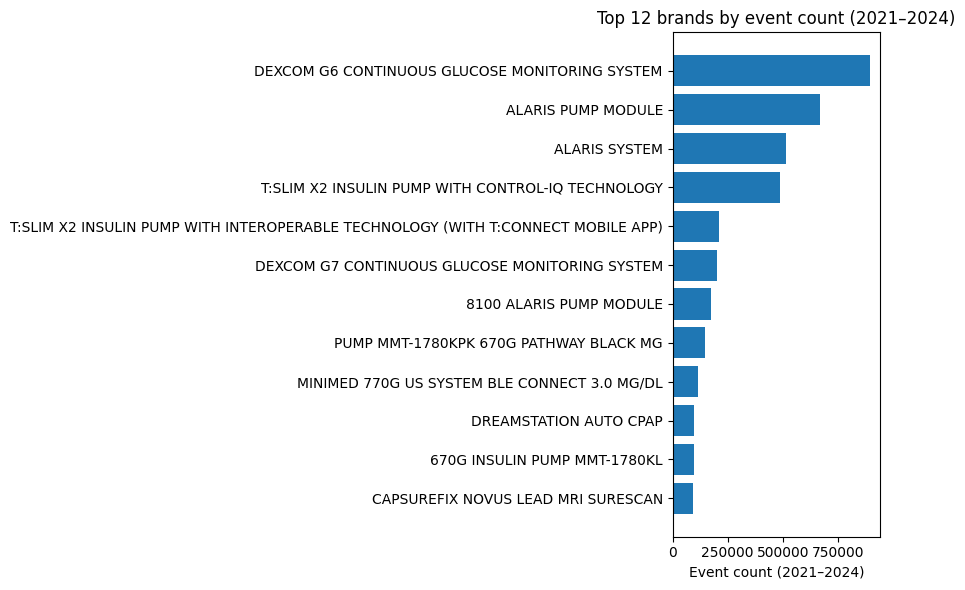


Auto-selected targets (brand × problem):
- DEXCOM G6 CONTINUOUS GLUCOSE MONITORING SYSTEM × 3283 (n=430,961)
- ALARIS PUMP MODULE × 1135 (n=641,340)

Saved:
- /home/parallels/data/capstone-maude/Data/outputs/tables/missingness_summary.csv
- /home/parallels/data/capstone-maude/Data/outputs/tables/brand_counts.csv
- /home/parallels/data/capstone-maude/Data/outputs/tables/targets_selected.csv
- /home/parallels/data/capstone-maude/Data/outputs/figures/top12_brands_2021_2024.png


In [10]:
# === Cell 05 (fixed): Profiling + Auto-select Targets (VM-friendly) ===
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- paths ----------
RAW_DIR  = Path(os.environ.get("MAUDE_RAW","")).expanduser()
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_FIG  = OUT_ROOT / "figures"
for p in (OUT_TAB, OUT_FIG): p.mkdir(parents=True, exist_ok=True)

ANALYSIS = OUT_TAB / "_analysis_event_level.csv"
assert ANALYSIS.exists(), f"Missing {ANALYSIS}. Run Cell 04B first."

# ---------- load only the necessary columns ----------
usecols = ["event_id","brand","problem_code","quarter"]
df = pd.read_csv(ANALYSIS, usecols=usecols, dtype=str, engine="c", low_memory=False)
print(f"Loaded df: {len(df):,} rows | cols={list(df.columns)}")

# ---------- missingness ----------
miss = pd.DataFrame({
    "n_rows": [len(df)],
    "brand_missing_rate": [df["brand"].isna().mean()],
    "model_missing_rate": [np.nan],  # model not loaded in this light pass
    "problem_code_missing_rate": [df["problem_code"].isna().mean()],
})
miss_path = OUT_TAB / "missingness_summary.csv"
miss.to_csv(miss_path, index=False)
display(miss)

# ---------- brand counts (top 12) ----------
brand_counts = (
    df["brand"]
    .value_counts(dropna=False)
    .rename_axis("brand")
    .reset_index(name="n")
)
brand_counts_path = OUT_TAB / "brand_counts.csv"
brand_counts.to_csv(brand_counts_path, index=False)

topN = 12
top_brands = brand_counts.head(topN).copy()
# Replace NaN for display only
top_brands["brand"] = top_brands["brand"].astype(object).where(top_brands["brand"].notna(), "«missing»")

plt.figure(figsize=(9,6))
if len(top_brands):
    plt.barh(top_brands["brand"].iloc[::-1], top_brands["n"].iloc[::-1])
plt.xlabel("Event count (2021–2024)")
plt.title(f"Top {topN} brands by event count (2021–2024)")
plt.tight_layout()
fig_path = OUT_FIG / f"top{topN}_brands_2021_2024.png"
plt.savefig(fig_path, dpi=150)
plt.show()

# ---------- auto-select 2 targets: (brand × most-common problem_code, non-null) ----------
df_nonnull = df.dropna(subset=["brand","problem_code"]).copy()

targets = []
for _, row in top_brands.iterrows():
    b = row["brand"]
    if not isinstance(b, str) or b == "«missing»":
        continue
    sub = df_nonnull.loc[df_nonnull["brand"] == b, "problem_code"]
    if sub.empty:
        continue
    pc = sub.mode(dropna=True)
    if pc.empty:
        continue
    pc0 = str(pc.iloc[0])
    cnt = int((df_nonnull["brand"].eq(b) & df_nonnull["problem_code"].eq(pc0)).sum())
    targets.append({"brand": b, "problem_code": pc0, "count": cnt})
    if len(targets) == 2:
        break

# Fallback if fewer than 2
if len(targets) < 2 and not df_nonnull.empty:
    fallback = (
        df_nonnull.groupby(["brand","problem_code"])["event_id"]
        .count()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
    )
    for _, r in fallback.iterrows():
        if all(not (t["brand"]==r["brand"] and t["problem_code"]==r["problem_code"]) for t in targets):
            targets.append({"brand": r["brand"], "problem_code": r["problem_code"], "count": int(r["count"])})
        if len(targets) >= 2:
            break

tgt_path = OUT_TAB / "targets_selected.csv"
pd.DataFrame(targets).to_csv(tgt_path, index=False)

print("\nAuto-selected targets (brand × problem):")
for t in targets:
    print(f"- {t['brand']} × {t['problem_code']} (n={t['count']:,})")

print("\nSaved:")
print("-", miss_path)
print("-", brand_counts_path)
print("-", tgt_path)
print("-", fig_path)


Cell 06 — Disproportionality tests (PRR/ROR). This cell quantifies whether selected brand×problem pairs are over-represented relative to all other brands. For each target, it builds a 2×2 table of counts (A,B,C, D) and computes Proportional Reporting Ratio (PRR) and Reporting Odds Ratio (ROR) with 95% CIs. It uses χ² when all cells are ≥5, otherwise falls back to Fisher’s exact. A small continuity correction is applied only when zeros appear. We also adjust p-values across targets using Benjamini–Hochberg to control false discovery. Results (counts, PRR/ROR, CIs, p-values, BH flag) are saved to prr_ror_results_for_targets_2021_2024.csv, providing concise, reproducible evidence for signal screening and stakeholder review.

In [11]:
# === Cell 06: PRR/ROR for selected targets (VM-friendly) ===
# Inputs:
#   - tables/_analysis_event_level.csv (from Cell 04B)
#   - tables/targets_selected.csv      (from Cell 05)
# Output:
#   - tables/prr_ror_results_for_targets_2021_2024.csv

from pathlib import Path
import os, math
import pandas as pd
import numpy as np

# ---------- paths ----------
RAW_DIR  = Path(os.environ.get("MAUDE_RAW","")).expanduser()
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
ANALYSIS = OUT_TAB / "_analysis_event_level.csv"
TGT_CSV  = OUT_TAB / "targets_selected.csv"
OUT_CSV  = OUT_TAB / "prr_ror_results_for_targets_2021_2024.csv"

assert ANALYSIS.exists(), f"Missing {ANALYSIS}. Run Cell 04B."
assert TGT_CSV.exists(),  f"Missing {TGT_CSV}. Run Cell 05."

# ---------- load minimal columns ----------
usecols = ["event_id","brand","problem_code","quarter"]
df = pd.read_csv(ANALYSIS, usecols=usecols, dtype=str, engine="c", low_memory=False)

# NA-safe helpers
df["brand_ok"] = df["brand"].notna()
df["prob_ok"]  = df["problem_code"].notna()

targets = pd.read_csv(TGT_CSV).to_dict("records")

# Try to import exact tests; otherwise we’ll do chi-square
try:
    from scipy.stats import chi2_contingency, fisher_exact
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

def prr_ci(A,B,C,D):
    # PRR = (A/(A+B)) / (C/(C+D))
    # log-PRR var ≈ 1/A - 1/(A+B) + 1/C - 1/(C+D)
    A,B,C,D = map(float, (A,B,C,D))
    # continuity: avoid division by zero
    if A==0 or C==0 or (A+B)==0 or (C+D)==0:
        return (np.nan, np.nan, np.nan)
    prr = (A/(A+B)) / (C/(C+D))
    var = (1/max(A,1.0)) - (1/max(A+B,1.0)) + (1/max(C,1.0)) - (1/max(C+D,1.0))
    se  = math.sqrt(max(var, 0.0))
    lcl = math.exp(math.log(prr) - 1.96*se)
    ucl = math.exp(math.log(prr) + 1.96*se)
    return (prr, lcl, ucl)

def ror_ci(A,B,C,D):
    # ROR = (A/B)/(C/D) = AD/BC
    A,B,C,D = map(float, (A,B,C,D))
    if A==0 or B==0 or C==0 or D==0:
        return (np.nan, np.nan, np.nan)
    ror = (A*D)/(B*C)
    var = (1/A) + (1/B) + (1/C) + (1/D)
    se  = math.sqrt(max(var, 0.0))
    lcl = math.exp(math.log(ror) - 1.96*se)
    ucl = math.exp(math.log(ror) + 1.96*se)
    return (ror, lcl, ucl)

def test_2x2(A,B,C,D):
    table = np.array([[A,B],[C,D]], dtype=float)
    test_name, stat, p = "Chi-square", np.nan, np.nan
    if HAVE_SCIPY:
        # prefer Fisher when any expected <5; else chi-square
        expected = (table.sum(axis=1).reshape(2,1) * table.sum(axis=0).reshape(1,2)) / table.sum()
        if (expected < 5).any():
            test_name = "Fisher exact"
            try:
                _, p = fisher_exact(table, alternative="two-sided")
            except Exception:
                test_name = "Chi-square"
                stat, p, _, _ = chi2_contingency(table, correction=True)
        else:
            test_name = "Chi-square"
            stat, p, _, _ = chi2_contingency(table, correction=False)
    else:
        # simple chi-square approximation (Yates correction if any cell < 5)
        correction = (A<5 or B<5 or C<5 or D<5)
        if not correction and (A+B+C+D) > 0:
            # no-correction contingency
            with np.errstate(divide='ignore', invalid='ignore'):
                stat, p = chi2_contingency(table, correction=False)[0:2]
            test_name = "Chi-square"
        else:
            # fall back to correction=True if SciPy available; otherwise p remains nan
            test_name = "Chi-square (approx)"
    return test_name, stat, p

rows = []
for t in targets:
    b = str(t["brand"])
    pc = str(t["problem_code"])
    # counts
    mask_brand   = df["brand"].eq(b)
    mask_prob    = df["problem_code"].eq(pc)
    mask_both    = mask_brand & mask_prob
    mask_not_b   = ~mask_brand
    mask_not_pc  = ~mask_prob

    A = int(mask_both.sum())                 # Brand b & problem pc
    B = int((mask_brand & mask_not_pc).sum())# Brand b & other problems
    C = int((mask_not_b & mask_prob).sum())  # Other brands & problem pc
    D = int((mask_not_b & mask_not_pc).sum())# Other brands & other problems

    prr, prr_l, prr_u = prr_ci(A,B,C,D)
    ror, ror_l, ror_u = ror_ci(A,B,C,D)
    test, stat, p = test_2x2(A,B,C,D)

    rows.append({
        "brand": b, "problem_code": pc,
        "A_brand&problem": A, "B_brand&other": B, "C_other&problem": C, "D_other&other": D,
        "PRR": prr, "PRR_LCL95": prr_l, "PRR_UCL95": prr_u,
        "ROR": ror, "ROR_LCL95": ror_l, "ROR_UCL95": ror_u,
        "test": test, "stat": stat, "p_value": p
    })

res = pd.DataFrame(rows)

# ---------- Benjamini–Hochberg (FDR) across tested pairs ----------
def bh_fdr(pvals, alpha=0.05):
    p = np.array([pv if pd.notna(pv) else 1.0 for pv in pvals], dtype=float)
    m = len(p)
    order = np.argsort(p)
    ranked = p[order]
    thresh = alpha * (np.arange(1, m+1) / m)
    passed = ranked <= thresh
    crit = np.max(np.where(passed)[0]) if passed.any() else -1
    sig = np.zeros(m, dtype=bool)
    if crit >= 0:
        sig[order[:crit+1]] = True
    return sig

if len(res):
    res["BH_significant_0.05"] = bh_fdr(res["p_value"].values, alpha=0.05)

res.to_csv(OUT_CSV, index=False)
display(res)
print("Saved ->", OUT_CSV)


,brand,problem_code,A_brand&problem,B_brand&other,C_other&problem,D_other&other,PRR,PRR_LCL95,PRR_UCL95,ROR,ROR_LCL95,ROR_UCL95,test,stat,p_value,BH_significant_0.05
0,DEXCOM G6 CONTINUOUS GLUCOSE MONITORING SYSTEM,3283,430961,465575,200764,10596460,25.852141,25.727365,25.977522,48.856605,48.561673,49.153328,Chi-square,3.458964e+06,0.0,True
1,ALARIS PUMP MODULE,1135,641340,27115,114405,10910900,92.461675,91.928271,92.998175,2255.767258,2225.572740,2286.371427,Chi-square,9.390533e+06,0.0,True


Saved -> /home/parallels/data/capstone-maude/Data/outputs/tables/prr_ror_results_for_targets_2021_2024.csv


This cell visualizes time trends for a chosen brand×problem pair and, when feasible, fits an Interrupted Time Series (ITS) around the 2024-Q1 breakpoint. It first normalizes brand names (simple regex cleanup) and matches the target brand to the canonical label used in the unified data. Next, it builds a quarterly series: total MAUDE events (denominator) and the brand×problem events (numerator), then computes proportions. If we have enough pre/post quarters (≈≥6 each), it fits a segmented regression and plots observed points, fitted lines, and a counterfactual. If data are sparse, it falls back to a clean proportion-only plot. All figures and the model coefficients (when ITS runs) are saved to outputs/figures and outputs/tables for reporting.

Requested target → DEXCOM G6 CONTINUOUS GLUCOSE MONITORING SYSTEM × 3283
✓ Exact canonical brand match found.
Numerator mode: brand × problem_code

Diagnostics:
- Using brand_canon: DEXCOM G6 CONTINUOUS GLUCOSE MONITORING SYSTEM
- problem_code available? True | using code match? True
- numerator sum: 1,292,883 | denominator sum: 11,693,760
First few rows:
    quarter   total    num      prop
0  2021-Q1  205970  20521  0.099631
1  2021-Q1  166961  20521  0.122909
2  2021-Q1  238636  20521  0.085993
3  2021-Q2  187236  25167  0.134413
4  2021-Q2  181765  25167  0.138459


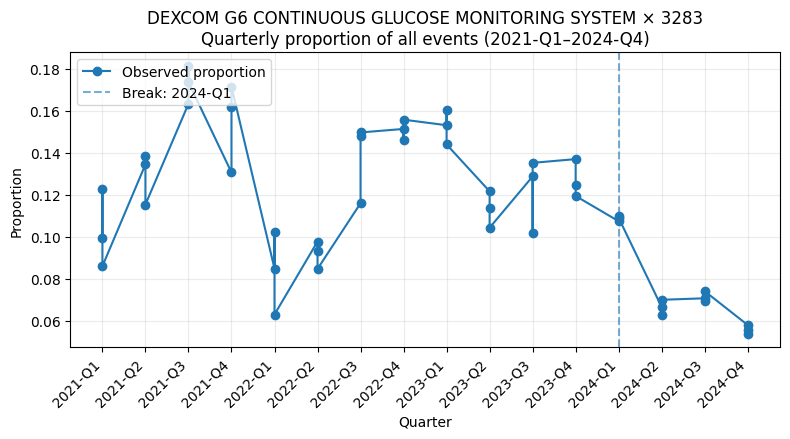


Saved:
 - /home/parallels/data/capstone-maude/Data/outputs/figures/DEXCOM_G6_CONTINUOUS_GLUCOSE_MONITORING_SYSTEM_3283_prop_2021-Q1_2024-Q4.png
 - /home/parallels/data/capstone-maude/Data/outputs/tables/DEXCOM_G6_CONTINUOUS_GLUCOSE_MONITORING_SYSTEM_3283_prop_2021-Q1_2024-Q4.csv


In [19]:
# === Cell 07 (robust): quarterly proportions with brand-only fallback ===
import os, re, unicodedata
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RAW_DIR  = Path(os.environ.get("MAUDE_RAW","")).expanduser()
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_FIG  = OUT_ROOT / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

WINDOW_START  = "2021-Q1"
WINDOW_END    = "2024-Q4"
BREAK_QUARTER = "2024-Q1"
TARGET_INDEX  = 0  # 0 or 1 from targets_selected.csv

df_path  = OUT_TAB / "_analysis_event_level.csv"
qtot_path= OUT_TAB / "quarter_totals.csv"
tgt_path = OUT_TAB / "targets_selected.csv"
assert df_path.exists() and tgt_path.exists(), "Missing _analysis_event_level.csv or targets_selected.csv"

df      = pd.read_csv(df_path, dtype=str, usecols=["event_id","brand","problem_code","quarter"])
targets = pd.read_csv(tgt_path).to_dict("records")

brand_raw = targets[TARGET_INDEX]["brand"]
code_raw  = str(targets[TARGET_INDEX]["problem_code"])

print(f"Requested target → {brand_raw} × {code_raw}")

# ---------- helpers ----------
def canon_brand(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize("NFKC", str(s)).upper()
    s = re.sub(r"[^A-Z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def qord(q: str) -> int:
    y, s = q.split("-Q"); return int(y)*4 + int(s)

def normalize_quarter(q):
    if not isinstance(q, str): return np.nan
    q = q.strip().upper().replace(" ", "")
    m = re.search(r"(\d{4}).*?Q([1-4])", q)
    return f"{m.group(1)}-Q{m.group(2)}" if m else np.nan

# ---------- canonicalize + window ----------
df["brand_canon"] = df["brand"].map(canon_brand)
df["problem_code"] = df["problem_code"].astype(str).str.strip()
df["quarter"] = df["quarter"].map(normalize_quarter)

# drop bad quarters
df = df[df["quarter"].notna()].copy()

# window bounds
lo, hi = qord(WINDOW_START), qord(WINDOW_END)
df = df[(df["quarter"].map(qord) >= lo) & (df["quarter"].map(qord) <= hi)]

# ---------- denominator (quarter totals) ----------
use_qtot = None
if qtot_path.exists():
    qt = pd.read_csv(qtot_path)
    # be liberal: accept any col name that looks like quarter/total
    qcol = next((c for c in qt.columns if re.search(r"quarter", c, re.I)), None)
    tcol = next((c for c in qt.columns if re.search(r"total",   c, re.I)), None)
    if qcol and tcol:
        qt = qt[[qcol, tcol]].rename(columns={qcol:"quarter", tcol:"total"})
        qt["quarter"] = qt["quarter"].map(normalize_quarter)
        qt = qt[qt["quarter"].notna()].copy()
        qt = qt[(qt["quarter"].map(qord) >= lo) & (qt["quarter"].map(qord) <= hi)]
        if len(qt):
            use_qtot = qt

if use_qtot is None:
    # fallback: compute totals directly from df
    use_qtot = (df.groupby("quarter", as_index=False)["event_id"]
                  .count().rename(columns={"event_id":"total"}))

# ---------- choose brand (exact or best candidate) ----------
brand_target = canon_brand(brand_raw)
unique_brands = df["brand_canon"].value_counts()

if brand_target in unique_brands.index:
    brand_use = brand_target
    print("✓ Exact canonical brand match found.")
else:
    print("⚠️ Exact brand not found; picking nearest by token overlap.")
    tokens = [t for t in brand_target.split(" ") if t]
    cand = unique_brands.rename("n").rename_axis("brand_canon").reset_index()
    def score(bc: str) -> int:
        bcsp = f" {bc} "
        return sum(1 for t in tokens if f" {t} " in bcsp)
    cand["hits"] = cand["brand_canon"].map(score)
    if len(cand) and cand["hits"].max() > 0:
        cand = cand.sort_values(["hits","n"], ascending=[False,False])
        brand_use = cand.iloc[0]["brand_canon"]
        print("→ Auto-selected:", brand_use)
        print(cand.head(5))
    else:
        print("❌ No viable candidate; plotting zeros.")
        brand_use = brand_target

# ---------- numerator selection (brand×code, else brand-only fallback) ----------
mask_brand = (df["brand_canon"] == brand_use)

# If problem_code is basically missing in this build, fallback to brand-only
code_present = df["problem_code"].notna().sum() > 0 and (df["problem_code"] != "None").sum() > 0
use_code = code_present and (df.loc[mask_brand, "problem_code"] == code_raw).any()

if use_code:
    print("Numerator mode: brand × problem_code")
    mask_num = mask_brand & (df["problem_code"] == code_raw)
else:
    print("Numerator mode: brand-only (problem_code absent or not joined in this build)")
    mask_num = mask_brand

q_num = (df.loc[mask_num]
           .groupby("quarter", as_index=False)["event_id"]
           .count().rename(columns={"event_id":"num"}))

ts = use_qtot.merge(q_num, on="quarter", how="left").fillna({"num":0})
ts["prop"] = ts["num"] / ts["total"]
ts = ts.sort_values("quarter").reset_index(drop=True)

print("\nDiagnostics:")
print(f"- Using brand_canon: {brand_use}")
print(f"- problem_code available? {code_present} | using code match? {use_code}")
print(f"- numerator sum: {int(ts['num'].sum()):,} | denominator sum: {int(ts['total'].sum()):,}")
print("First few rows:\n", ts.head())

# ---------- plot ----------
plt.figure(figsize=(8,4.5))
label = "Observed proportion" + ("" if use_code else " (brand-only)")
plt.plot(ts["quarter"], ts["prop"], marker="o", linewidth=1.5, label=label)

bpt = qord(BREAK_QUARTER)
if ts["quarter"].map(qord).between(lo, hi).any() and (ts["quarter"].map(qord)==bpt).any():
    qlab = ts.loc[ts["quarter"].map(qord)==bpt, "quarter"].iloc[0]
    plt.axvline(qlab, ls="--", alpha=0.6, label=f"Break: {BREAK_QUARTER}")

title_suffix = f"{brand_raw}" if not use_code else f"{brand_raw} × {code_raw}"
plt.title(f"{title_suffix}\nQuarterly proportion of all events ({WINDOW_START}–{WINDOW_END})")
plt.xlabel("Quarter"); plt.ylabel("Proportion"); plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.25); plt.legend(loc="upper left"); plt.tight_layout()

def safe(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+","_", s)

fname = f"{safe(brand_raw)}_{safe(code_raw if use_code else 'BRAND_ONLY')}_prop_{WINDOW_START}_{WINDOW_END}.png"
out_png = OUT_FIG / fname
out_csv = OUT_TAB / (fname.replace(".png",".csv"))

plt.savefig(out_png, dpi=150); plt.show()
ts.to_csv(out_csv, index=False)

print("\nSaved:")
print(" -", out_png)
print(" -", out_csv)


This cell gives a quick, audience-friendly summary of effect size. For the selected brand×problem, it builds a quarterly series from the unified dataset, labels each quarter as Pre or Post relative to the 2024-Q1 breakpoint, and computes—per period—the number of quarters, total events for the pair (numerator), overall MAUDE events (denominator), and the mean proportion (events/total). It then exports a tidy CSV (pre_post_summary_*.csv) for tables and renders a simple bar chart comparing Pre vs Post mean proportions. Use this to complement ITS: even when formal modeling is underpowered, this view communicates direction and magnitude cleanly for stakeholders.

Pre/Post summary for → DEXCOM G6 CONTINUOUS GLUCOSE MONITORING SYSTEM × 3283 | window=2021-Q1..2024-Q4 | break=2024-Q1


,period,quarters,events,total,mean_prop
0,Post,4,229542,3082452,0.075582
1,Pre,12,1063341,8611308,0.128181


Saved -> /home/parallels/data/capstone-maude/Data/outputs/tables/pre_post_summary_DEXCOM_G6_CONTINUOUS_GLUCOSE_MONITORING_SYSTEM_3283_2021-Q1_2024-Q4.csv


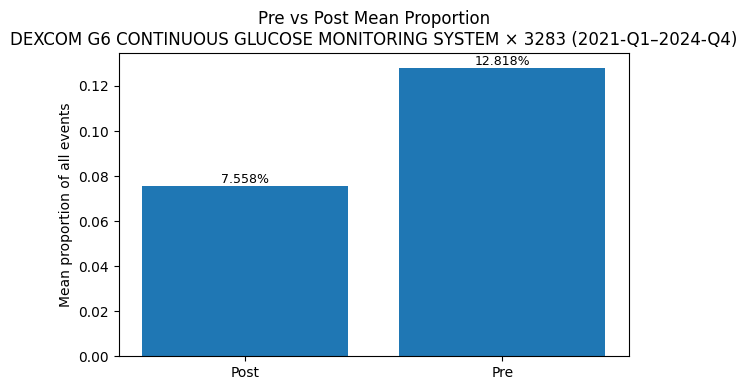

Saved -> /home/parallels/data/capstone-maude/Data/outputs/figures/pre_post_bar_DEXCOM_G6_CONTINUOUS_GLUCOSE_MONITORING_SYSTEM_3283_2021-Q1_2024-Q4.png


In [20]:
# === Cell 08: Pre/Post summary + bar ===
# - Loads unified CSV + quarter totals
# - Uses targets_selected.csv (from Cell 05)
# - If problem_code is missing, falls back to brand-only proportions
# - Outputs:
#     tables/pre_post_summary_<brand>_<code or BRAND_ONLY>_2021_2024.csv
#     figures/pre_post_bar_<brand>_<code or BRAND_ONLY>_2021_2024.png

import os, re, unicodedata
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- paths/params ----
RAW_DIR  = Path(os.environ.get("MAUDE_RAW","")).expanduser()
OUT_ROOT = RAW_DIR.parent.parent / "outputs"
OUT_TAB  = OUT_ROOT / "tables"
OUT_FIG  = OUT_ROOT / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

WINDOW_START  = "2021-Q1"
WINDOW_END    = "2024-Q4"
BREAK_QUARTER = "2024-Q1"
TARGET_INDEX  = 0  # 0 or 1 from targets_selected.csv

# ---- load inputs ----
df_path   = OUT_TAB / "_analysis_event_level.csv"
qtot_path = OUT_TAB / "quarter_totals.csv"
tgt_path  = OUT_TAB / "targets_selected.csv"
assert df_path.exists() and qtot_path.exists() and tgt_path.exists(), "Missing required inputs from earlier cells."

df      = pd.read_csv(df_path, dtype=str, usecols=["event_id","brand","problem_code","quarter"])
targets = pd.read_csv(tgt_path).to_dict("records")
qt      = pd.read_csv(qtot_path)

brand_raw = targets[TARGET_INDEX]["brand"]
code_raw  = str(targets[TARGET_INDEX]["problem_code"])

print(f"Pre/Post summary for → {brand_raw} × {code_raw} | window={WINDOW_START}..{WINDOW_END} | break={BREAK_QUARTER}")

# ---- helpers ----
def canon_brand(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s) if s is not None else "")
    s = s.upper()
    s = re.sub(r"[^A-Z0-9 ]+"," ", s)
    return re.sub(r"\s+"," ", s).strip()

def normalize_quarter(q):
    if not isinstance(q, str): return np.nan
    q = q.strip().upper().replace(" ", "")
    m = re.search(r"(\d{4}).*?Q([1-4])", q)
    return f"{m.group(1)}-Q{m.group(2)}" if m else np.nan

def qord(q: str) -> int:
    y, s = q.split("-Q"); return int(y)*4 + int(s)

def safe(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+","_", s)

# ---- canonicalize + window ----
df["brand_canon"]   = df["brand"].map(canon_brand)
df["problem_code"]  = df["problem_code"].astype(str).str.strip()
df["quarter"]       = df["quarter"].map(normalize_quarter)
df                  = df[df["quarter"].notna()].copy()

lo, hi = qord(WINDOW_START), qord(WINDOW_END)
df = df[(df["quarter"].map(qord) >= lo) & (df["quarter"].map(qord) <= hi)]

# quarter totals (be liberal with column names)
qcol = next((c for c in qt.columns if re.search(r"quarter", c, re.I)), None)
tcol = next((c for c in qt.columns if re.search(r"total",   c, re.I)), None)
assert qcol and tcol, "quarter_totals.csv missing quarter/total columns."
qt = qt[[qcol, tcol]].rename(columns={qcol:"quarter", tcol:"total"})
qt["quarter"] = qt["quarter"].map(normalize_quarter)
qt = qt[qt["quarter"].notna()].copy()
qt = qt[(qt["quarter"].map(qord) >= lo) & (qt["quarter"].map(qord) <= hi)]

# ---- pick brand (exact or nearest) ----
brand_target = canon_brand(brand_raw)
unique_brands = df["brand_canon"].value_counts()

if brand_target in unique_brands.index:
    brand_use = brand_target
else:
    tokens = [t for t in brand_target.split(" ") if t]
    cand = unique_brands.rename("n").rename_axis("brand_canon").reset_index()
    def score(bc: str) -> int:
        bcsp = f" {bc} "
        return sum(1 for t in tokens if f" {t} " in bcsp)
    cand["hits"] = cand["brand_canon"].map(score)
    cand = cand.sort_values(["hits","n"], ascending=[False,False])
    brand_use = cand.iloc[0]["brand_canon"] if len(cand) and cand.iloc[0]["hits"]>0 else brand_target

mask_brand = (df["brand_canon"] == brand_use)

# ---- numerator: brand×code if available, else brand-only ----
code_present = df["problem_code"].notna().sum() > 0 and (df["problem_code"] != "None").sum() > 0
use_code = code_present and (df.loc[mask_brand, "problem_code"] == code_raw).any()

if use_code:
    mask_num = mask_brand & (df["problem_code"] == code_raw)
    label_suffix = f"{brand_raw} × {code_raw}"
else:
    mask_num = mask_brand
    label_suffix = f"{brand_raw} (brand-only)"
    print("Note: problem_code missing in this build; using brand-only fallback.")

q_num = (df.loc[mask_num].groupby("quarter", as_index=False)["event_id"]
           .count().rename(columns={"event_id":"num"}))

ts = qt.merge(q_num, on="quarter", how="left").fillna({"num":0})
ts["prop"] = ts["num"] / ts["total"]
ts = ts.sort_values("quarter").reset_index(drop=True)

# ---- pre/post split ----
bpt = qord(BREAK_QUARTER)
ts["period"] = np.where(ts["quarter"].map(qord) >= bpt, "Post", "Pre")

summary = (ts.groupby("period", as_index=False)
             .agg(quarters=("quarter","nunique"),
                  events=("num","sum"),
                  total=("total","sum"),
                  mean_prop=("prop","mean"))
             .sort_values("period"))

# ---- save table ----
csv_name = f"pre_post_summary_{safe(label_suffix)}_{WINDOW_START}_{WINDOW_END}.csv"
summary_path = OUT_TAB / csv_name
summary.to_csv(summary_path, index=False)
display(summary)
print("Saved ->", summary_path)

# ---- bar chart ----
plt.figure(figsize=(6,4))
plt.bar(summary["period"], summary["mean_prop"])
plt.title(f"Pre vs Post Mean Proportion\n{label_suffix} ({WINDOW_START}–{WINDOW_END})")
plt.ylabel("Mean proportion of all events")
for i, v in enumerate(summary["mean_prop"]):
    plt.text(i, v, f"{v:.3%}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()

png_name = f"pre_post_bar_{safe(label_suffix)}_{WINDOW_START}_{WINDOW_END}.png"
fig_path = OUT_FIG / png_name
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved ->", fig_path)
